**Explorartory Data Analysis(EDA)**

In [6]:
import math
import collections
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import MinMaxScaler

# Visualization Libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Tuning & Splitting Libraries
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

**Data**

Used data includes data of 100 engines, each doing their respective number of cycles as per their functional lifecycle. During each cycle the sensors installed collects the data in each respective cycle. Based on this collected data we need to build a model which would predict the remaining useful life(RUL, time before which engine goes for maintenance to avoid unexpected breakdown) of a already/newly installed engine based on its current cycle data

In [7]:
# Reading the data
jet_data = pd.read_csv('/content/drive/MyDrive/Time Series/CMaps/train_FD001.txt', sep=" ", header=None)
jet_data.columns = ["id","cycle","op1","op2","op3","sensor1","sensor2","sensor3","sensor4","sensor5"
                    ,"sensor6","sensor7","sensor8","sensor9","sensor10","sensor11","sensor12","sensor13"
                    ,"sensor14","sensor15","sensor16","sensor17","sensor18","sensor19"
                    ,"sensor20","sensor21","sensor22","sensor23"]

jet_data.drop(['sensor22', 'sensor23'], axis=1, inplace=True)

jet_id_and_rul = jet_data.groupby(['id'])[["id" ,"cycle"]].max()
jet_id_and_rul.set_index('id', inplace=True)

In [8]:
jet_data.head()

,id,cycle,op1,op2,op3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


**Data Manipulation**

The test data does not have RUL column so for model validation purposes we will add the column externally in the dataframe

In [9]:
def RUL_calculator(df, df_max_cycles):
    max_cycle = df_max_cycles["cycle"]
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='id', right_index=True)
    result_frame["RUL"] = result_frame["max_cycle"] - result_frame["cycle"] 
    result_frame.drop(['max_cycle'], axis=1, inplace=True)
    return result_frame

jet_data = RUL_calculator(jet_data, jet_id_and_rul)

In [10]:
jet_data.describe()

,id,cycle,op1,op2,op3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,RUL
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,20631.00,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,518.67,642.680934,1590.523119,1408.933782,1.462000e+01,...,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705,107.807862
std,29.227633,68.880990,0.002187,0.000293,0.0,0.00,0.500053,6.131150,9.000605,1.776400e-15,...,0.071919,19.076176,0.037505,1.387812e-17,1.548763,0.0,0.0,0.180746,0.108251,68.880990
min,1.000000,1.000000,-0.008700,-0.000600,100.0,518.67,641.210000,1571.040000,1382.250000,1.462000e+01,...,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200,0.000000
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,518.67,642.325000,1586.260000,1402.360000,1.462000e+01,...,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800,51.000000
50%,52.000000,104.000000,0.000000,0.000000,100.0,518.67,642.640000,1590.100000,1408.040000,1.462000e+01,...,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900,103.000000
75%,77.000000,156.000000,0.001500,0.000300,100.0,518.67,643.000000,1594.380000,1414.555000,1.462000e+01,...,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800,155.000000
max,100.000000,362.000000,0.008700,0.000600,100.0,518.67,644.530000,1616.910000,1441.490000,1.462000e+01,...,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400,361.000000


In [11]:
jet_data.head()

,id,cycle,op1,op2,op3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


**Visualizing Data**

We will visualize the data to determine the relevance of data and figure out the model determining attributes

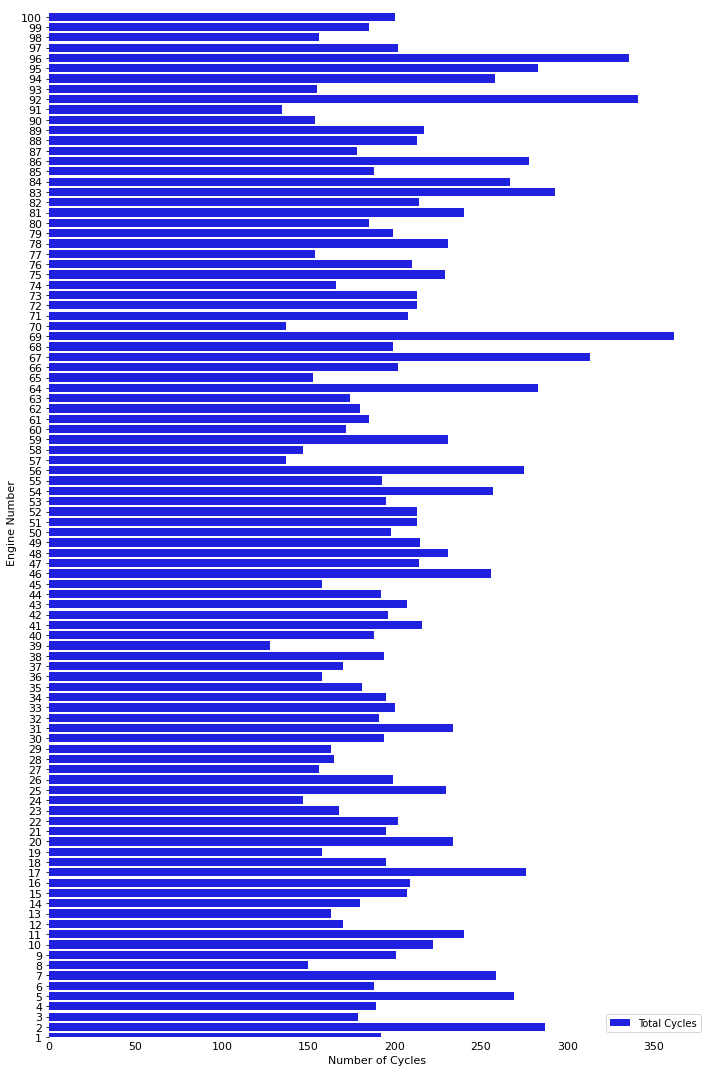

In [12]:
jet_id_and_rul = jet_data.groupby(['id'])[["id" ,"cycle"]].max()

f, ax = plt.subplots(figsize=(10, 15))
sns.set_color_codes("pastel")
sns.barplot(x="cycle", y="id", data=jet_id_and_rul, label="Total Cycles", color="blue", orient = 'h', dodge=False)
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylim=(0, 100), ylabel="",xlabel="Automobile collisions per billion miles")
sns.despine(left=True, bottom=True)
ax.tick_params(labelsize=11)
ax.tick_params(length=0, axis='x')
ax.set_ylabel("Engine Number", fontsize=11)
ax.set_xlabel("Number of Cycles", fontsize=11)
plt.tight_layout()
plt.show()

Mean number of cycles after which jet engine fails is 206


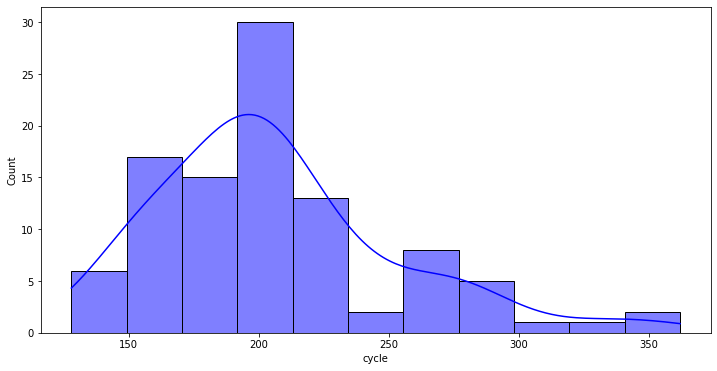

In [13]:
plt.subplots(figsize=(12, 6))
sns.histplot(jet_id_and_rul["cycle"], kde = True, color='blue');
print("Mean number of cycles after which jet engine fails is "+ str(math.floor(jet_id_and_rul["cycle"].mean())))

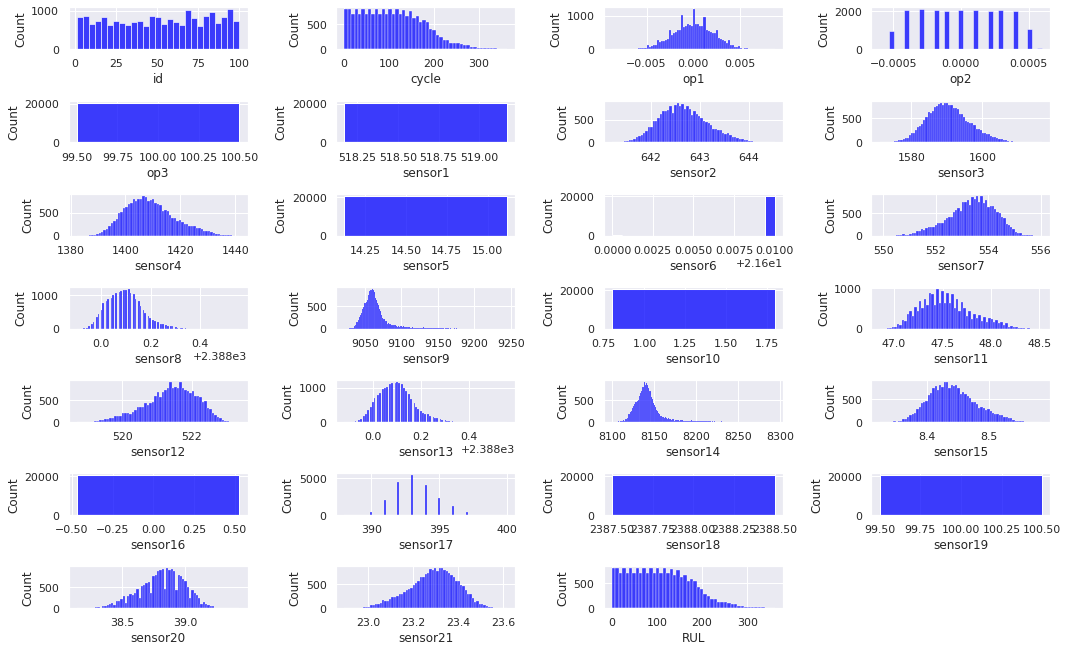

In [14]:
sns.set()
fig = plt.figure(figsize = [15,10])
cols = jet_data.columns
cnt = 1
for col in cols :
    plt.subplot(8,4,cnt)
    sns.histplot(jet_data[col],color='blue')
    cnt+=1
plt.tight_layout()
plt.show()

**Result of above sensors**

As we could see there are many sensor data which aren't following the normal distribution, we will tend to ignore those sensors for our model training. We would try to reduce the curse of dimensionality by doing so

**Correlation Matrix**

To see wheather the selected attributes are not related to each other. This way we will be able to reduce some more attributes, making our model free from overfitting

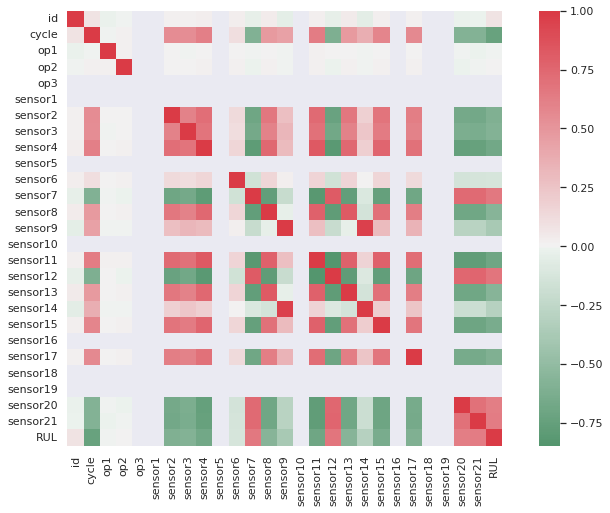

In [15]:
plt.figure(figsize=(13,8))
cmap = sns.diverging_palette(500, 10, as_cmap=True)
sns.heatmap(jet_data.corr(), cmap =cmap, center=0, annot=False, square=True);

**Deletion of non contributing parameters into the analysis**

Using the above correlation heatmap, We can safely ignore the parameters with lesser correlation with RUL. we can infer that the following parameters are not related to the RUL.

id, op1, op2, op3 sensor1, sensor5, sensor6, sensor10 sensor16, sensor18, sensor19

In [16]:
jet_relevant_data = jet_data.drop(["cycle", "op1", "op2", "op3", "sensor1", "sensor5", "sensor6", "sensor10", "sensor16", "sensor18", "sensor19", "sensor14", "sensor13", "sensor12", "sensor11"], axis=1)

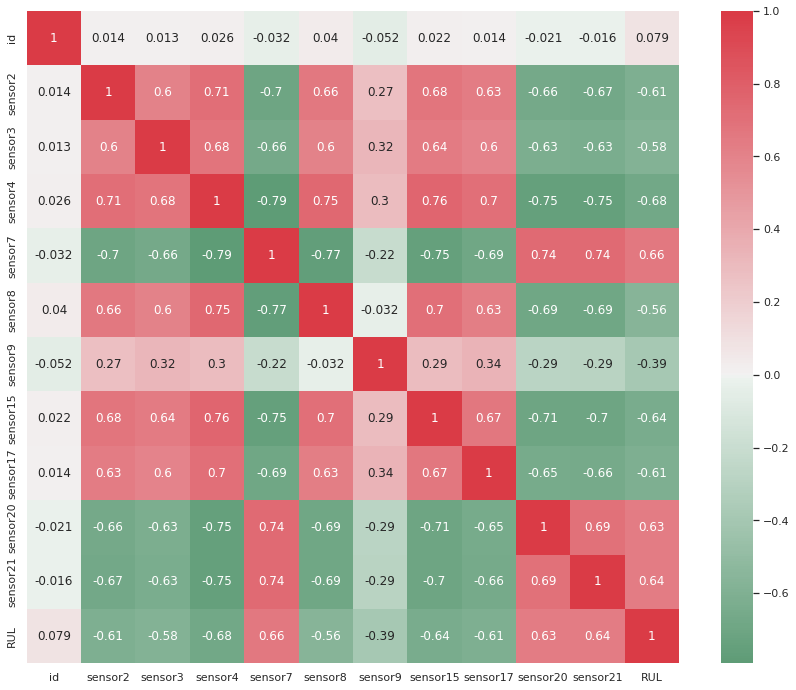

In [17]:
plt.figure(figsize=(15, 12))
cmap = sns.diverging_palette(500, 10, as_cmap=True)
sns.heatmap(jet_relevant_data.corr(), cmap =cmap, center=0, annot=True, square=True);

In [18]:
def plot_sensor(sensor_name,X):
    plt.figure(figsize=(13,5))
    for i in X['id'].unique():
        if (i % 10 == 0):  # only plot every engine
            plt.plot('RUL', sensor_name, 
                     data=X[X['id']==i].rolling(8).mean())
            plt.axvline(30, color='red', linestyle='dashed', linewidth=2)
    plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
    plt.xticks(np.arange(0, 275, 25))
    plt.ylabel(sensor_name)
    plt.xlabel('Remaining Use fulLife')
    plt.show()

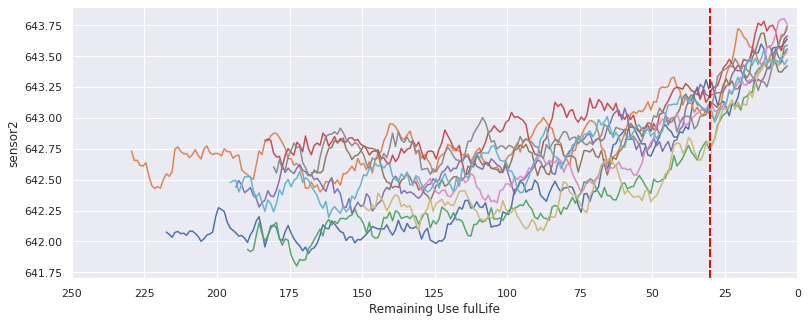

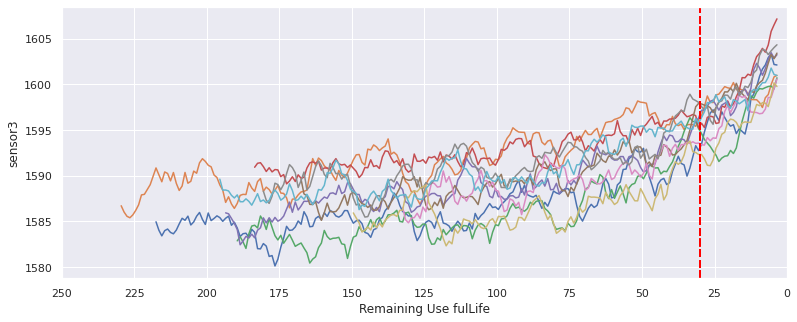

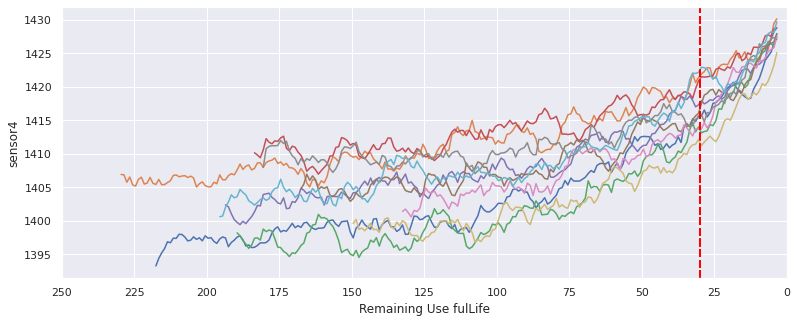

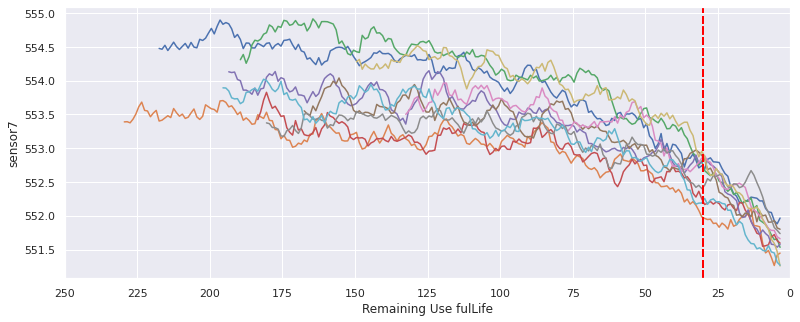

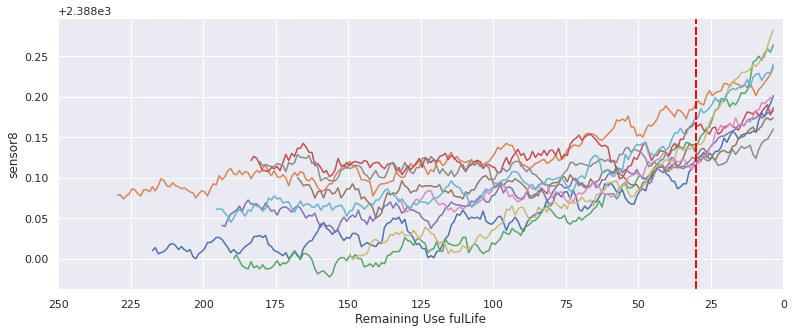

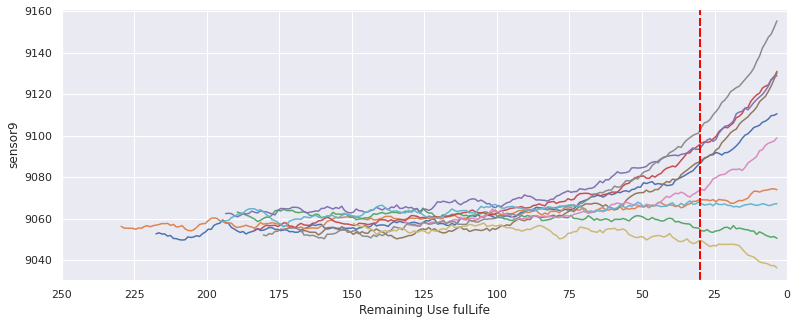

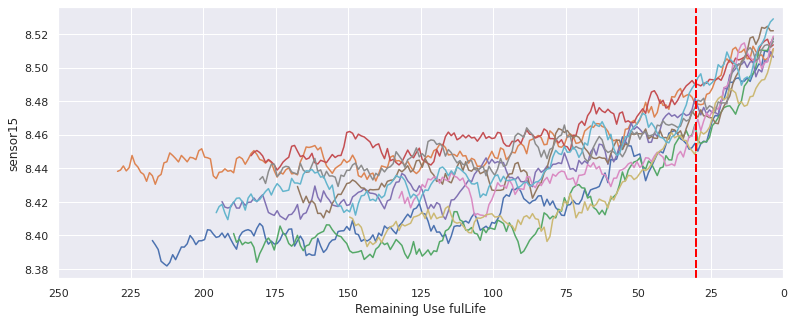

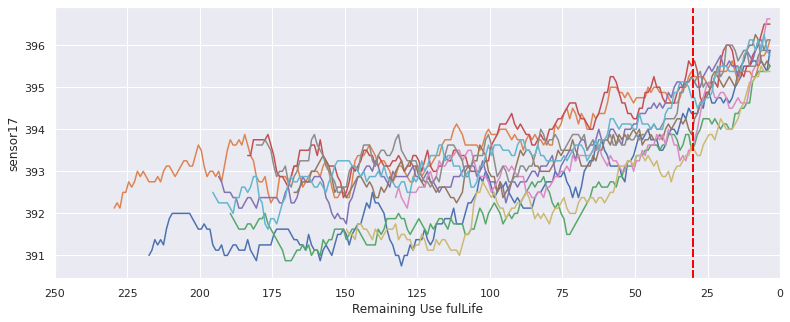

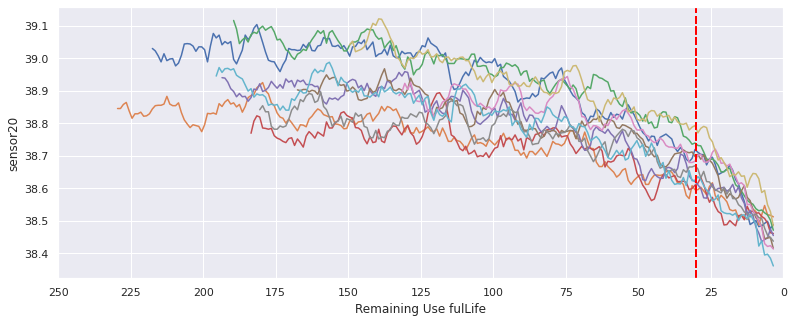

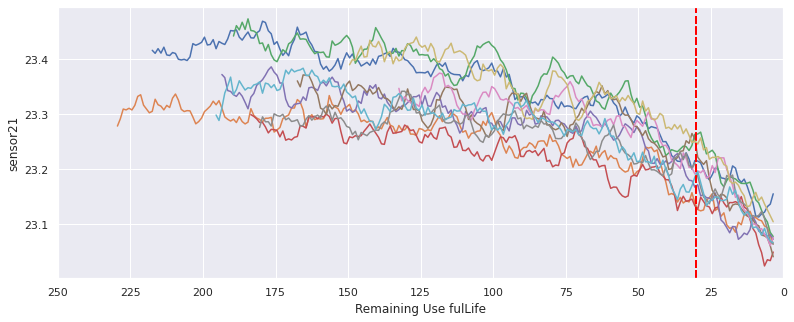

In [19]:
for sensor in jet_relevant_data.drop(['id', 'RUL'], axis=1).columns:
    plot_sensor(sensor, jet_relevant_data)

In [20]:
# Based on the above data variation, we removed sensor 9
jet_relevant_data.drop('sensor9', axis=1, inplace=True)

In [21]:
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(jet_relevant_data.drop(['id', 'RUL'], axis=1))
scaled_features = pd.DataFrame(scaled_features, columns=jet_relevant_data.drop(['id', 'RUL'], axis=1).columns)

In [22]:
scaled_features['id'] = jet_relevant_data['id']
scaled_features['RUL'] = jet_relevant_data['RUL']

In [23]:
scaled_features.head()

,sensor2,sensor3,sensor4,sensor7,sensor8,sensor15,sensor17,sensor20,sensor21,id,RUL
0,0.183735,0.406802,0.309757,0.726248,0.242424,0.363986,0.333333,0.713178,0.724662,1,191
1,0.283133,0.453019,0.352633,0.628019,0.212121,0.411312,0.333333,0.666667,0.731014,1,190
2,0.343373,0.369523,0.370527,0.710145,0.272727,0.357445,0.166667,0.627907,0.621375,1,189
3,0.343373,0.256159,0.331195,0.740741,0.318182,0.166603,0.333333,0.573643,0.662386,1,188
4,0.349398,0.257467,0.404625,0.668277,0.242424,0.402078,0.416667,0.589147,0.704502,1,187


In [24]:
data = scaled_features.copy()

In [25]:
cycle=30
data['label'] = data['RUL'].apply(lambda x: 1 if x <= cycle else 0)

In [ ]:
sns.pairplot(data.drop(['id'], axis=1), hue="label")

Output hidden; open in https://colab.research.google.com to view.

In [26]:
y = data['label']
X = data.drop(['RUL', 'id', 'label'], axis=1)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=3)

print('X_train shape : ',X_train.shape)
print('X_test shape : ',X_test.shape)
print('y_train shape : ',y_train.shape)
print('y_test shape : ',y_test.shape)

X_train shape :  (16504, 9)
X_test shape :  (4127, 9)
y_train shape :  (16504,)
y_test shape :  (4127,)


**Applying CNN Model**

In [ ]:
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
# Convert the data to NumPy arrays
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [ ]:
# Define the CNN model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(9, 1)),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
# Compile the model with binary cross-entropy loss and Adam optimizer
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Reshape the data to fit the CNN input shape
X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:
# Fit the model on the training data
model.fit(X_train_cnn, y_train, epochs=10, batch_size=32)

Epoch 1/10
516/516 [==============================] - 2s 3ms/step - loss: 0.2140 - accuracy: 0.9187
Epoch 2/10
516/516 [==============================] - 1s 2ms/step - loss: 0.1306 - accuracy: 0.9451
Epoch 3/10
516/516 [==============================] - 1s 2ms/step - loss: 0.1268 - accuracy: 0.9461
Epoch 4/10
516/516 [==============================] - 2s 3ms/step - loss: 0.1256 - accuracy: 0.9450
Epoch 5/10
516/516 [==============================] - 2s 5ms/step - loss: 0.1250 - accuracy: 0.9465
Epoch 6/10
516/516 [==============================] - 2s 4ms/step - loss: 0.1231 - accuracy: 0.9473
Epoch 7/10
516/516 [==============================] - 1s 3ms/step - loss: 0.1239 - accuracy: 0.9466
Epoch 8/10
516/516 [==============================] - 1s 3ms/step - loss: 0.1216 - accuracy: 0.9463
Epoch 9/10
516/516 [==============================] - 1s 2ms/step - loss: 0.1222 - accuracy: 0.9469
Epoch 10/10
516/516 [==============================] - 1s 3ms/step - loss: 0.1218 - accuracy: 0.9477

In [ ]:
# Predict on the test data
y_pred_prob = model.predict(X_test_cnn)

129/129 [==============================] - 1s 3ms/step


In [ ]:
# Convert the probabilities to binary predictions using a threshold of 0.5
y_pred = (y_pred_prob >= 0.5).astype(int)

In [ ]:
# Evaluate the performance of the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

In [ ]:
print('Accuracy: %.2f%%' % (accuracy * 100))
print('Precision: %.2f%%' % (precision * 100))
print('Recall: %.2f%%' % (recall * 100))
print('F1 Score: %.2f%%' % (f1 * 100))

Accuracy: 94.65%
Precision: 87.15%
Recall: 75.08%
F1 Score: 80.66%


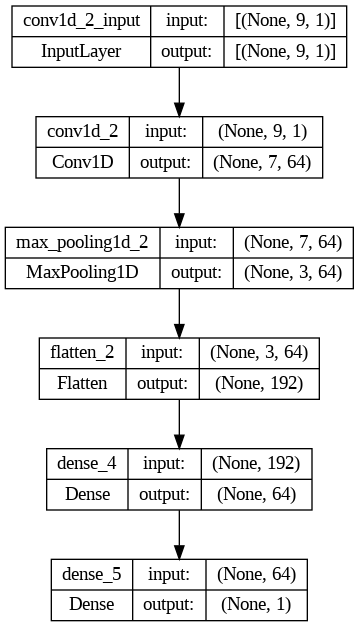

In [4]:
from tensorflow.keras.utils import plot_model

# Define the CNN model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(9, 1)),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Plot the model architecture
plot_model(model, show_shapes=True)

**Applying LSTM Model**

In [28]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=3)

print('X_train shape : ',X_train.shape)
print('X_test shape : ',X_test.shape)
print('y_train shape : ',y_train.shape)
print('y_test shape : ',y_test.shape)

X_train shape :  (16504, 9)
X_test shape :  (4127, 9)
y_train shape :  (16504,)
y_test shape :  (4127,)


In [30]:
# Reshape the data to fit the LSTM input shape
X_train_lstm = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Fit the model to the training data
model.fit(X_train_lstm, y_train, epochs=10, batch_size=32, verbose=1)

Epoch 1/10
516/516 [==============================] - 41s 11ms/step - loss: 0.3080 - accuracy: 0.8856
Epoch 2/10
516/516 [==============================] - 7s 14ms/step - loss: 0.1668 - accuracy: 0.9295
Epoch 3/10
516/516 [==============================] - 5s 9ms/step - loss: 0.1597 - accuracy: 0.9342
Epoch 4/10
516/516 [==============================] - 6s 12ms/step - loss: 0.1575 - accuracy: 0.9348
Epoch 5/10
516/516 [==============================] - 5s 10ms/step - loss: 0.1477 - accuracy: 0.9392
Epoch 6/10
516/516 [==============================] - 5s 9ms/step - loss: 0.1296 - accuracy: 0.9452
Epoch 7/10
516/516 [==============================] - 6s 12ms/step - loss: 0.1246 - accuracy: 0.9483
Epoch 8/10
516/516 [==============================] - 5s 10ms/step - loss: 0.1239 - accuracy: 0.9473
Epoch 9/10
516/516 [==============================] - 5s 10ms/step - loss: 0.1226 - accuracy: 0.9481
Epoch 10/10
516/516 [==============================] - 6s 11ms/step - loss: 0.1213 - accurac

In [ ]:
# Predict on the test data
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob >= 0.5).astype(int)

129/129 [==============================] - 2s 4ms/step


In [ ]:
# Evaluate the performance of the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

In [ ]:
print('Accuracy: %.2f%%' % (accuracy * 100))
print('Precision: %.2f%%' % (precision * 100))
print('Recall: %.2f%%' % (recall * 100))
print('F1 Score: %.2f%%' % (f1 * 100))

Accuracy: 94.72%
Precision: 84.14%
Recall: 79.48%
F1 Score: 81.74%


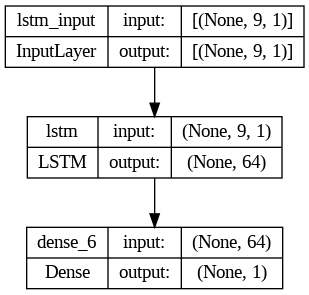

In [31]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Build the LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Plot the model architecture
plot_model(model, show_shapes=True)


**Applying Attention-Based Neural Network Model**

In [33]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Attention
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=3)

print('X_train shape : ',X_train.shape)
print('X_test shape : ',X_test.shape)
print('y_train shape : ',y_train.shape)
print('y_test shape : ',y_test.shape)

X_train shape :  (16504, 9)
X_test shape :  (4127, 9)
y_train shape :  (16504,)
y_test shape :  (4127,)


In [35]:
# Define the input shape
input_shape = (9,)

In [ ]:
# Define the model architecture
inputs = Input(shape=input_shape)
x = Dense(64, activation='relu')(inputs)
x = Dropout(0.2)(x)
x = Attention()([x, x])
outputs = Dense(1, activation='sigmoid')(x)
model = Model(inputs=inputs, outputs=outputs)

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
516/516 [==============================] - 7s 9ms/step - loss: 0.3272 - accuracy: 0.8711 - val_loss: 0.1614 - val_accuracy: 0.9358
Epoch 2/10
516/516 [==============================] - 6s 11ms/step - loss: 0.1512 - accuracy: 0.9394 - val_loss: 0.1444 - val_accuracy: 0.9431
Epoch 3/10
516/516 [==============================] - 6s 11ms/step - loss: 0.1489 - accuracy: 0.9400 - val_loss: 0.1456 - val_accuracy: 0.9426
Epoch 4/10
516/516 [==============================] - 6s 11ms/step - loss: 0.1435 - accuracy: 0.9430 - val_loss: 0.1456 - val_accuracy: 0.9426
Epoch 5/10
516/516 [==============================] - 3s 6ms/step - loss: 0.1465 - accuracy: 0.9420 - val_loss: 0.1394 - val_accuracy: 0.9418
Epoch 6/10
516/516 [==============================] - 2s 4ms/step - loss: 0.1430 - accuracy: 0.9434 - val_loss: 0.1399 - val_accuracy: 0.9423
Epoch 7/10
516/516 [==============================] - 1s 3ms/step - loss: 0.1416 - accuracy: 0.9430 - val_loss: 0.1390 - val_accuracy: 0.9418
Epo

In [ ]:
# Evaluate the model
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

129/129 [==============================] - 0s 2ms/step


In [ ]:
print('Accuracy: %.2f%%' % (accuracy * 100))
print('Precision: %.2f%%' % (precision * 100))
print('Recall: %.2f%%' % (recall * 100))
print('F1 Score: %.2f%%' % (f1 * 100))

Accuracy: 94.06%
Precision: 84.36%
Recall: 73.78%
F1 Score: 78.71%


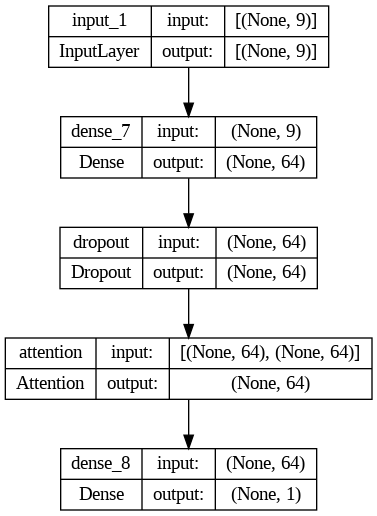

In [36]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Attention

# Define the model architecture
inputs = Input(shape=input_shape)
x = Dense(64, activation='relu')(inputs)
x = Dropout(0.2)(x)
x = Attention()([x, x])
outputs = Dense(1, activation='sigmoid')(x)
model = Model(inputs=inputs, outputs=outputs)

# Plot the model architecture
plot_model(model, show_shapes=True)